# This notebook does the model-based ROI-wise correlation analysis
The subject-wise shifts in starting point were correlated with the "left/right cue > neutral" cue-contrast to find subregions that show activity that is related to implementing response bias. After multiple-comparison correction, no correlation was significant.

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import statsmodels

%load_ext rpy2.ipython
%matplotlib inline

#### Load beta-values, calculate contrasts

In [2]:
all_betas = pd.read_pickle('./derivatives/STN_GLM_betavalues.pkl')
betas_cues = all_betas.loc[all_betas['event type'].isin(['cue_neutral', 'cue_payoff'])].set_index('subject')

def get_contrast(x):    
    return pd.Series({'cue_contrast': x.loc[x['event type'] == 'cue_payoff', 'beta'].values[0] - x.loc[x['event type'] == 'cue_neutral', 'beta'].values[0]})

cue_contrast = betas_cues.groupby(['subject', 'roi'])[['event type', 'beta']].apply(get_contrast).reset_index()
cue_contrast['dataset'] = np.hstack([np.repeat(['ds-01'], 19*6), np.repeat(['ds-02'], 14*6)])

# difficulty
betas_easyhard = all_betas.loc[all_betas['event type'].isin(['easy', 'hard'])]

def get_contrast(x):
    return pd.Series({'difficulty_contrast': x.loc[x['event type'] == 'hard', 'beta'].values[0] - x.loc[x['event type'] == 'easy', 'beta'].values[0]})

diff_contrast = betas_easyhard.groupby(['subject', 'roi'])[['event type', 'beta']].apply(get_contrast).reset_index()
diff_contrast['dataset'] = np.hstack([np.repeat(['ds-01'], 19*6), np.repeat(['ds-02'], 14*6)])

beta_contrasts = pd.merge(left=cue_contrast, right=diff_contrast)
beta_contrasts.head()

,subject,roi,cue_contrast,dataset,difficulty_contrast
0,1,signal_l_A,0.148641,ds-01,0.013394
1,1,signal_l_B,0.209342,ds-01,-0.210553
2,1,signal_l_C,0.166442,ds-01,-0.338578
3,1,signal_r_A,0.033935,ds-01,-0.054502
4,1,signal_r_B,0.102775,ds-01,-0.040659


#### Load parameters, merge with betas, z-score both the contrast-betas and parameter differences

In [3]:
all_params = pd.read_csv('./derivatives/BMAParameters.csv', index_col=0)
all_params.index.name = 'subject'

In [4]:
combined_data = pd.merge(beta_contrasts, all_params, on=['subject'])
combined_data['hemisphere'] = combined_data['roi'].str.split('_').apply(lambda x: x[1])
combined_data['subregion'] = combined_data['roi'].str.split('_').apply(lambda x: x[2])
combined_data = combined_data.set_index(['subject', 'dataset', 'roi', 'hemisphere', 'subregion'])

# Z-score
combined_data = combined_data.apply(lambda x: (x-x.mean()) / x.std()).reset_index()

combined_data.head()

,subject,dataset,roi,hemisphere,subregion,cue_contrast,difficulty_contrast,a,v.low,v.high,z,zshiftBias,vshift,vshiftBias,t0
0,1,ds-01,signal_l_A,l,A,0.672225,0.007651,-0.494685,-0.820052,-0.581689,-1.651324,-0.121708,-0.277176,-0.645916,0.380063
1,1,ds-01,signal_l_B,l,B,1.019504,-1.227817,-0.494685,-0.820052,-0.581689,-1.651324,-0.121708,-0.277176,-0.645916,0.380063
2,1,ds-01,signal_l_C,l,C,0.774064,-1.934107,-0.494685,-0.820052,-0.581689,-1.651324,-0.121708,-0.277176,-0.645916,0.380063
3,1,ds-01,signal_r_A,r,A,0.015972,-0.366918,-0.494685,-0.820052,-0.581689,-1.651324,-0.121708,-0.277176,-0.645916,0.380063
4,1,ds-01,signal_r_B,r,B,0.409817,-0.290547,-0.494685,-0.820052,-0.581689,-1.651324,-0.121708,-0.277176,-0.645916,0.380063


#### cue-related starting point shifts?
#### Any between-dataset differences?

signal_l_A
signal_l_B
signal_l_C
signal_r_A
signal_r_B
signal_r_C


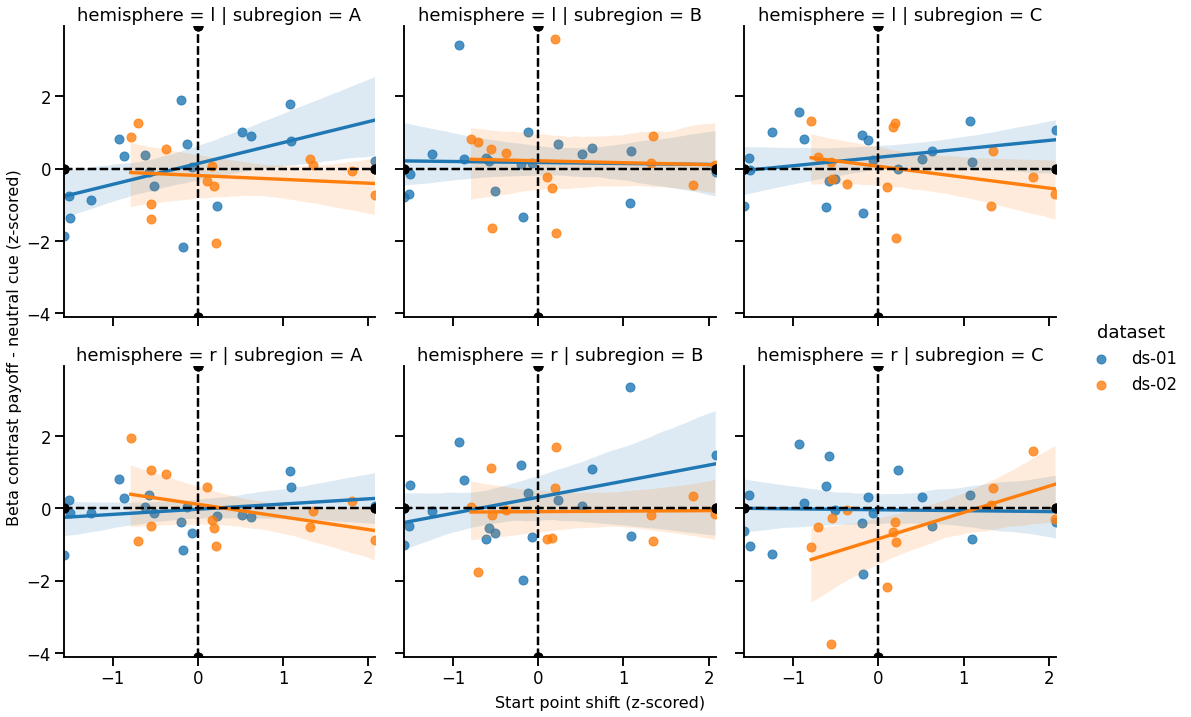

In [5]:
sns.set_context('talk')
fac = sns.lmplot(x='zshiftBias',
                 y='cue_contrast', data=combined_data, 
                 row='hemisphere', col='subregion', hue='dataset', truncate=True)

fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')

fac.fig.text(x=0, y=0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           s='Beta contrast payoff - neutral cue (z-scored)', #this is the text in the ylabel
           size=16, #customize the fontsize if you will
           rotation=90) #vertical text

#overall xlabel
fac.fig.text(x=0.5, y=0, 
             horizontalalignment='center', #make sure it's aligned at center horizontally
             s='Start point shift (z-scored)', #this is the text in the xlabel
             size=16)

## get correlation estimates
statistics = []
for roi in combined_data.roi.unique():
    print(roi)
    r, p = scipy.stats.pearsonr(combined_data.loc[(combined_data.roi==roi), 'cue_contrast'], 
                                combined_data.loc[(combined_data.roi==roi), 'zshiftBias'])
    statistics.append({'mask': roi, 'r':r, 'p':p})
    
statistics = pd.DataFrame(statistics)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(statistics['p'], method='fdr_bh')
statistics['p.fdr'] = p_fdr
statistics['contrast'] = 'zbias'

##### get Bayes Factors

In [6]:
%%R -i combined_data -i statistics -o statistics
library(BayesFactor)

combined_data$hemisphere <- factor(combined_data$hemisphere)
combined_data$subregion <- factor(combined_data$subregion)
combined_data$dataset <- factor(combined_data$dataset)
combined_data$subject <- factor(combined_data$subject)

# segment-wise correlations
#bayesfactors <- data.frame(roi=unique(combined_data$roi), bf=NA)
for(roi in unique(combined_data$roi)) {
    print(roi)
    idx = combined_data$roi == roi
    bf = correlationBF(combined_data[idx, 'zshiftBias'], combined_data[idx, 'cue_contrast'])
    statistics[statistics$mask==roi, 'bf'] <- extractBF(bf)$bf
}

R[write to console]: Loading required package: coda

R[write to console]: Loading required package: Matrix

R[write to console]: ************
Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************



[1] "signal_l_A"
[1] "signal_l_B"
[1] "signal_l_C"
[1] "signal_r_A"
[1] "signal_r_B"
[1] "signal_r_C"


#### Cue-related drift rate effects?

signal_l_A
signal_l_B
signal_l_C
signal_r_A
signal_r_B
signal_r_C


,mask,r,p,p.fdr,contrast
0,signal_l_A,-0.136772,0.455405,0.805990,vbias
1,signal_l_B,0.077917,0.671658,0.805990,vbias
2,signal_l_C,0.007681,0.966721,0.966721,vbias
3,signal_r_A,-0.083258,0.650529,0.805990,vbias
4,signal_r_B,-0.185789,0.308648,0.805990,vbias
5,signal_r_C,-0.262562,0.146559,0.805990,vbias


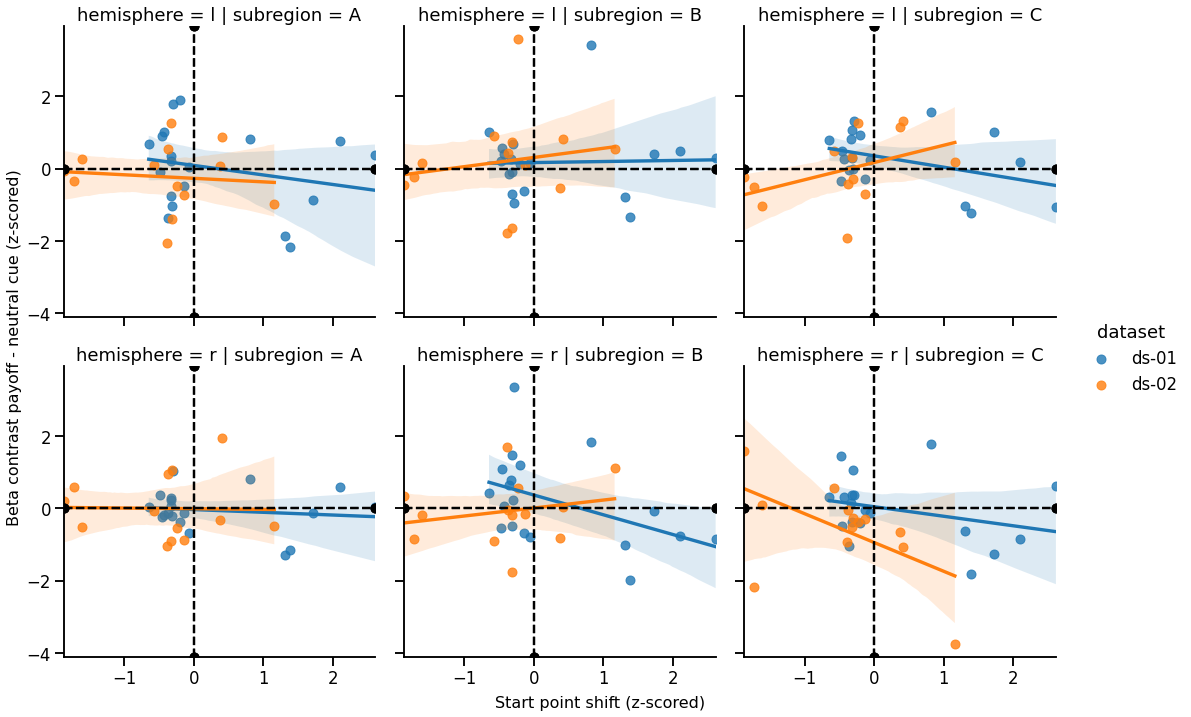

In [7]:
sns.set_context('talk')
fac = sns.lmplot(x='vshiftBias',
                 y='cue_contrast', data=combined_data, 
                 row='hemisphere', col='subregion', hue='dataset', truncate=True)

fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')

fac.fig.text(x=0, y=0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           s='Beta contrast payoff - neutral cue (z-scored)', #this is the text in the ylabel
           size=16, #customize the fontsize if you will
           rotation=90) #vertical text

#overall xlabel
fac.fig.text(x=0.5, y=0, 
             horizontalalignment='center', #make sure it's aligned at center horizontally
             s='Start point shift (z-scored)', #this is the text in the xlabel
             size=16)

# get correlation coefficients
results = []
for roi in combined_data.roi.unique():
    print(roi)
    r, p = scipy.stats.pearsonr(combined_data.loc[(combined_data.roi==roi), 'cue_contrast'], 
                                combined_data.loc[(combined_data.roi==roi), 'vshiftBias'])
    results.append({'mask': roi, 'r':r, 'p':p})
    
results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results['contrast'] = 'vbias'
results

##### get Bayes Factors

In [8]:
%%R -i combined_data -i results -o results
library(BayesFactor)

combined_data$hemisphere <- factor(combined_data$hemisphere)
combined_data$subregion <- factor(combined_data$subregion)
combined_data$dataset <- factor(combined_data$dataset)
combined_data$subject <- factor(combined_data$subject)

# segment-wise correlations
#bayesfactors <- data.frame(roi=unique(combined_data$roi), bf=NA)
results$bf <- NA
for(roi in unique(combined_data$roi)) {
    print(roi)
    idx = combined_data$roi == roi
    bf = correlationBF(combined_data[idx, 'vshiftBias'], combined_data[idx, 'cue_contrast'])
    results[results$mask==roi, 'bf'] <- extractBF(bf)$bf
}

[1] "signal_l_A"
[1] "signal_l_B"
[1] "signal_l_C"
[1] "signal_r_A"
[1] "signal_r_B"
[1] "signal_r_C"


In [9]:
statistics = pd.concat([statistics, results])

#### Easy vs hard?

signal_l_A
signal_l_B
signal_l_C
signal_r_A
signal_r_B
signal_r_C


,mask,r,p,p.fdr,contrast
0,signal_l_A,0.206796,0.256123,0.690622,vdifficulty
1,signal_l_B,0.165113,0.366483,0.690622,vdifficulty
2,signal_l_C,0.250637,0.166478,0.690622,vdifficulty
3,signal_r_A,-0.073176,0.690622,0.690622,vdifficulty
4,signal_r_B,-0.116949,0.523842,0.690622,vdifficulty
5,signal_r_C,0.076878,0.675799,0.690622,vdifficulty


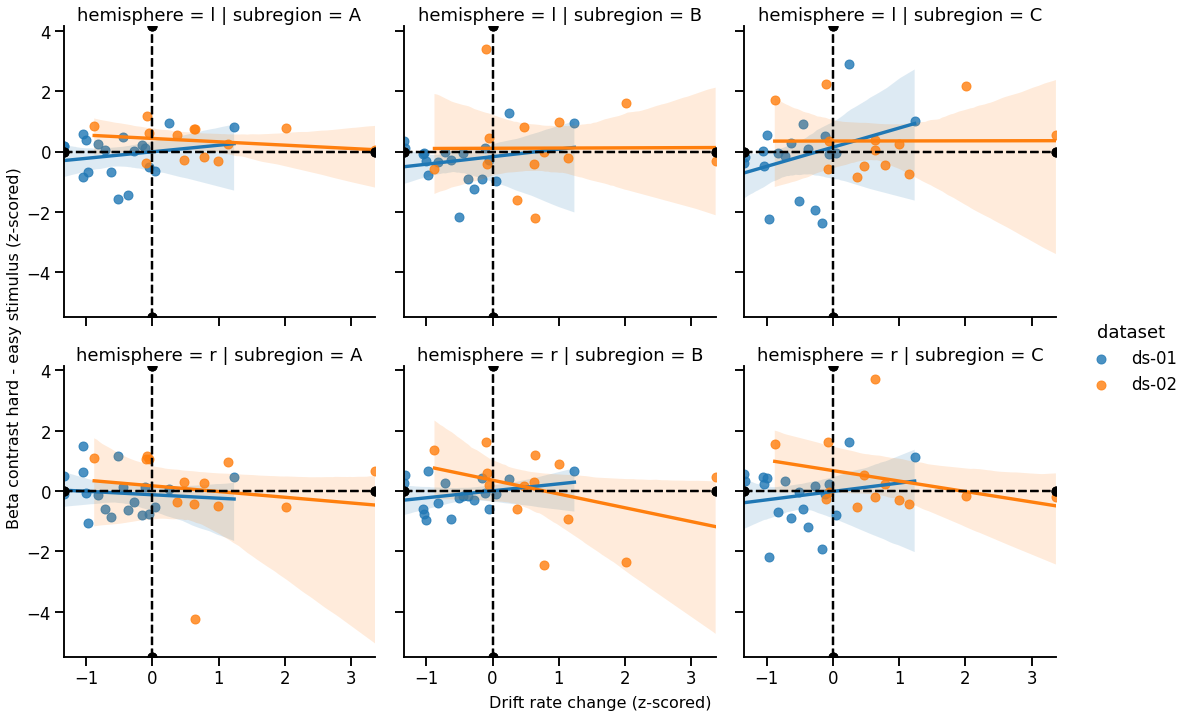

In [10]:
fac = sns.lmplot(x='vshift',
                 y='difficulty_contrast', data=combined_data, 
                 row='hemisphere', col='subregion', hue='dataset', truncate=True)

fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')

fac.fig.text(x=0, y=0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           s='Beta contrast hard - easy stimulus (z-scored)', #this is the text in the ylabel
           size=16, #customize the fontsize if you will
           rotation=90) #vertical text

#overall xlabel
fac.fig.text(x=0.5, y=0, 
             horizontalalignment='center', #make sure it's aligned at center horizontally
             s='Drift rate change (z-scored)', #this is the text in the xlabel
             size=16)

# correlation estimates
results = []
for roi in combined_data.roi.unique():
    print(roi)
    r, p = scipy.stats.pearsonr(combined_data.loc[(combined_data.roi==roi), 'difficulty_contrast'], 
                                combined_data.loc[(combined_data.roi==roi), 'vshift'])
    results.append({'mask': roi, 'r':r, 'p':p})
    
results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results['contrast'] = 'vdifficulty'
results

##### Get bayes factors

In [11]:
%%R -i combined_data -i results -o results
library(BayesFactor)

combined_data$hemisphere <- factor(combined_data$hemisphere)
combined_data$subregion <- factor(combined_data$subregion)
combined_data$dataset <- factor(combined_data$dataset)
combined_data$subject <- factor(combined_data$subject)

# segment-wise correlations
#bayesfactors <- data.frame(roi=unique(combined_data$roi), bf=NA)
results$bf <- NA
for(roi in unique(combined_data$roi)) {
    print(roi)
    idx = combined_data$roi == roi
    bf = correlationBF(combined_data[idx, 'vshift'], combined_data[idx, 'difficulty_contrast'])
    results[results$mask==roi, 'bf'] <- extractBF(bf)$bf
}

[1] "signal_l_A"
[1] "signal_l_B"
[1] "signal_l_C"
[1] "signal_r_A"
[1] "signal_r_B"
[1] "signal_r_C"


In [12]:
statistics = pd.concat([statistics, results])
statistics

,mask,r,p,p.fdr,contrast,bf
0,signal_l_A,0.243933,0.178490,0.736786,zbias,0.844215
1,signal_l_B,-0.028616,0.876452,0.893351,zbias,0.393001
2,signal_l_C,-0.024678,0.893351,0.893351,zbias,0.391958
3,signal_r_A,-0.059408,0.746711,0.893351,zbias,0.406733
4,signal_r_B,0.194435,0.286265,0.736786,zbias,0.632992
5,signal_r_C,0.164465,0.368393,0.736786,zbias,0.550064
0,signal_l_A,-0.136772,0.455405,0.805990,vbias,0.493814
1,signal_l_B,0.077917,0.671658,0.805990,vbias,0.420080
2,signal_l_C,0.007681,0.966721,0.966721,vbias,0.389241
3,signal_r_A,-0.083258,0.650529,0.805990,vbias,0.424707


## Figure for paper

Attempt 1: Collapse across subregions

Text(0.5, 0, 'Start point shift (z-scored)')

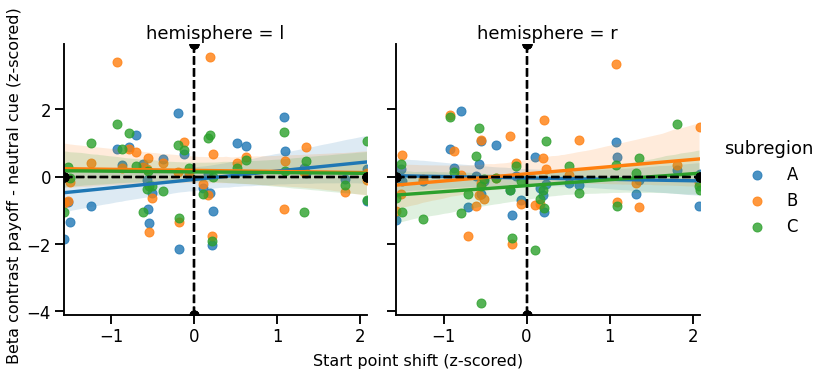

In [13]:
sns.set_context('talk')
fac = sns.lmplot(x='zshiftBias',
                 y='cue_contrast', data=combined_data, 
                 col='hemisphere', hue='subregion', 
                 #hue='dataset', 
                 truncate=True)

fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')

fac.fig.text(x=0, y=0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           s='Beta contrast payoff - neutral cue (z-scored)', #this is the text in the ylabel
           size=16, #customize the fontsize if you will
           rotation=90) #vertical text

#overall xlabel
fac.fig.text(x=0.5, y=0, 
             horizontalalignment='center', #make sure it's aligned at center horizontally
             s='Start point shift (z-scored)', #this is the text in the xlabel
             size=16)

For drift rate and starting point effect

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


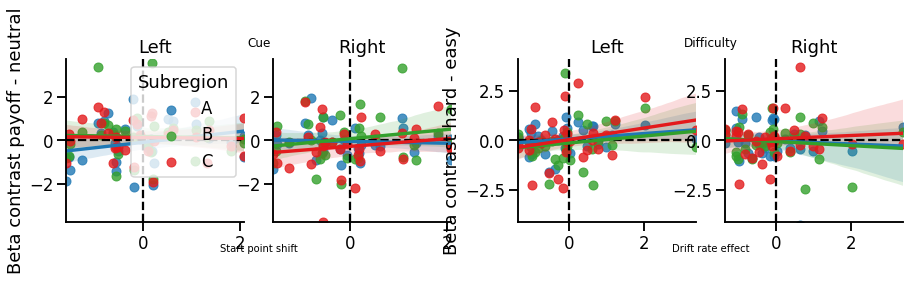

In [14]:
f, ax = plt.subplots(1,5, gridspec_kw={'wspace': 0.2, 'width_ratios': [1,1,.05,1,1]})
for ax_n in [0,1,3,4]:
    ax[ax_n].axhline(y=0, c='k', ls='--')
    ax[ax_n].axvline(x=0, c='k', ls='--')

for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='zshiftBias', y='cue_contrast', 
                data=combined_data.loc[(combined_data.hemisphere=='l')&(combined_data.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[0], label=subregion)
ax[0].set_ylim([-3.75, 3.75])
ax[0].set_title('Left')
ax[0].set_xlabel('')
ax[0].set_ylabel('Beta contrast payoff - neutral')

for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='zshiftBias', y='cue_contrast', 
                data=combined_data.loc[(combined_data.hemisphere=='r')&(combined_data.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[1])
ax[1].set_ylim([-3.75, 3.75])
ax[1].set_title('Right')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='vshift', y='difficulty_contrast', 
                data=combined_data.loc[(combined_data.hemisphere=='l')&(combined_data.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[3])
ax[3].set_ylim([-4.1, 4.1])
ax[3].set_title('Left')
ax[3].set_ylabel('Beta contrast hard - easy')
ax[3].set_xlabel('')
    
for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='vshift', y='difficulty_contrast', 
                data=combined_data.loc[(combined_data.hemisphere=='r')&(combined_data.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[4])
ax[4].set_ylim([-4.1, 4.1])
ax[4].set_title('Right')
ax[4].set_ylabel('')
ax[4].set_xlabel('')

## subplots title: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
ext = []
#loop over the columns (j) and rows(i) to populate subplots
for j in range(5):
#     for i in range(1):
#         axes[i,j].scatter(x, y[:,4*i+j], c=colors[j], s=25) 
#     # each axes in the top row gets its own axes title
#     axes[0,j].set_title('title {}'.format(j+1))
    # save the axes bounding boxes for later use
    ext.append([ax[j].get_window_extent().x0, ax[j].get_window_extent().width ])

# from the axes bounding boxes calculate the optimal position of the column spanning title
#f.subplots_adjust(top=0.85)
inv = f.transFigure.inverted()
width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )
width_right = ext[3][0]+(ext[4][0]+ext[4][1]-ext[3][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0],0.95,"Cue", va="center", ha="center", size=12)
plt.figtext(right_center[0],0.95,"Difficulty", va="center", ha="center", size=12)

# x-axis labels
plt.figtext(left_center[0],0,"Start point shift", va="center", ha="center", size=10)
plt.figtext(right_center[0],0,"Drift rate effect", va="center", ha="center", size=10)

sns.despine()
ax[2].axis('off')

ax[0].legend(title='Subregion')
#plt.subplots_adjust(right=.95)
#h, l = ax[0].get_legend_handles_labels()
#f.legend(h, l, loc='center right', title='Subregion')
f.tight_layout()
f.set_size_inches(15,3)

In [15]:
# f.savefig('figures/figure5.pdf', bbox_inches='tight')

## That didn't really work well
Attempt 2

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


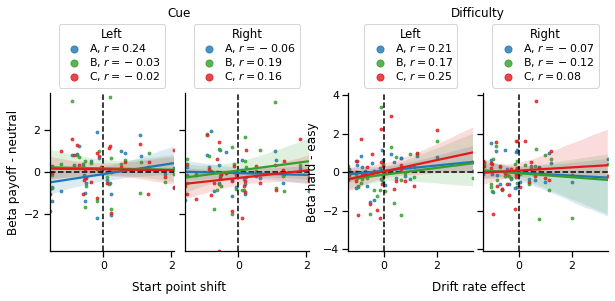

In [16]:
sns.set_context('notebook')
font = {'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

s = 8


f, ax = plt.subplots(2,5, gridspec_kw={'wspace': 0.1, 'height_ratios': [0.2, 0.8], 'width_ratios': [1,1,.15,1,1]}, 
                     figsize=(10,4))
for ax_n in [0,1,3,4]:
    ax[1,ax_n].axhline(y=0, c='k', ls='--')
    ax[1,ax_n].axvline(x=0, c='k', ls='--')
    
r_ = []
for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='zshiftBias', y='cue_contrast', 
                data=combined_data.loc[(combined_data.hemisphere=='l')&(combined_data.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[1,0], label=subregion, scatter_kws={'s': s})
    r_.append(np.corrcoef(combined_data.loc[(combined_data.hemisphere=='l') & (combined_data.subregion==subregion), 'zshiftBias'],
                          combined_data.loc[(combined_data.hemisphere=='l') & (combined_data.subregion==subregion), 'cue_contrast'])[0,1])
ax[1,0].set_ylim([-3.75, 3.75])
# ax[0,0].set_title('Left')
ax[1,0].set_xlabel('')
ax[1,0].set_ylabel('Beta payoff - neutral')
h, l = ax[1,0].get_legend_handles_labels()
leg = ax[1,0].legend(h, ['A, $r = ' + str(np.round(r_[0],2))+'$',
                 'B, $r = ' + str(np.round(r_[1],2))+'$',
                 'C, $r = ' + str(np.round(r_[2],2))+'$'], loc='lower center', bbox_to_anchor=(0.5,1.), 
                     title='Left',  labelspacing=0.1, handletextpad=0.35)
plt.setp(leg.get_title(),fontsize='small')
for handle in leg.legendHandles:
    handle.set_sizes([50.0])


r_ = []
for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='zshiftBias', y='cue_contrast', 
                data=combined_data.loc[(combined_data.hemisphere=='r')&(combined_data.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[1,1], label=subregion, scatter_kws={'s': s})
    r_.append(np.corrcoef(combined_data.loc[(combined_data.hemisphere=='r') & (combined_data.subregion==subregion), 'zshiftBias'],
                          combined_data.loc[(combined_data.hemisphere=='r') & (combined_data.subregion==subregion), 'cue_contrast'])[0,1])

ax[1,1].set_ylim([-3.75, 3.75])
# ax[0,1].set_title('Right')
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('')
h, l = ax[1,1].get_legend_handles_labels()
leg = ax[1,1].legend(h, ['A, $r = ' + str(np.round(r_[0],2))+'$',
                 'B, $r = ' + str(np.round(r_[1],2))+'$',
                 'C, $r = ' + str(np.round(r_[2],2))+'$'], loc='lower center', bbox_to_anchor=(0.5,1.), 
                     title='Right', labelspacing=0.1, handletextpad=0.35)
plt.setp(leg.get_title(),fontsize='small')
for handle in leg.legendHandles:
    handle.set_sizes([50.0])


r_ = []
for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='vshift', y='difficulty_contrast', 
                data=combined_data.loc[(combined_data.hemisphere=='l')&(combined_data.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[1,3], label=subregion, scatter_kws={'s': s})
    r_.append(np.corrcoef(combined_data.loc[(combined_data.hemisphere=='l')&(combined_data.subregion==subregion), 'vshift'],
                          combined_data.loc[(combined_data.hemisphere=='l')&(combined_data.subregion==subregion), 'difficulty_contrast'])[0,1])

ax[1,3].set_ylim([-4.1, 4.1])
# ax[0,3].set_title('Left')
ax[1,3].set_ylabel('Beta hard - easy')
ax[1,3].set_xlabel('')
h, l = ax[1,3].get_legend_handles_labels()
leg = ax[1,3].legend(h, ['A, $r = ' + str(np.round(r_[0],2))+'$',
                 'B, $r = ' + str(np.round(r_[1],2))+'$',
                 'C, $r = ' + str(np.round(r_[2],2))+'$'], loc='lower center', bbox_to_anchor=(0.5,1.), 
                     title='Left', labelspacing=0.1, handletextpad=0.35)
plt.setp(leg.get_title(),fontsize='small')
for handle in leg.legendHandles:
    handle.set_sizes([50.0])


r_ = []
for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='vshift', y='difficulty_contrast', 
                data=combined_data.loc[(combined_data.hemisphere=='r')&(combined_data.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[1,4], label=subregion, scatter_kws={'s': s})
    r_.append(np.corrcoef(combined_data.loc[(combined_data.hemisphere=='r')&(combined_data.subregion==subregion), 'vshift'],
                          combined_data.loc[(combined_data.hemisphere=='r')&(combined_data.subregion==subregion), 'difficulty_contrast'])[0,1])

ax[1,4].set_ylim([-4.1, 4.1])
# ax[0,4].set_title('Right')
ax[1,4].set_ylabel('')
ax[1,4].set_xlabel('')
h, l = ax[1,4].get_legend_handles_labels()
leg = ax[1,4].legend(h, ['A, $r = ' + str(np.round(r_[0],2))+'$',
                   'B, $r = ' + str(np.round(r_[1],2))+'$',
                   'C, $r = ' + str(np.round(r_[2],2))+'$'], loc='lower center', bbox_to_anchor=(0.5,1.), 
                     title='Right', labelspacing=0.1, handletextpad=0.35)
plt.setp(leg.get_title(),fontsize='small')
for handle in leg.legendHandles:
    handle.set_sizes([50.0])

ax[1,1].tick_params(labelleft=False)
ax[1,4].tick_params(labelleft=False)


## subplots title: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
ext = []
#loop over the columns (j) and rows(i) to populate subplots
for j in range(5):
#     for i in range(1):
#         axes[i,j].scatter(x, y[:,4*i+j], c=colors[j], s=25) 
#     # each axes in the top row gets its own axes title
#     axes[0,j].set_title('title {}'.format(j+1))
    # save the axes bounding boxes for later use
    ext.append([ax[1,j].get_window_extent().x0, ax[1,j].get_window_extent().width ])

# from the axes bounding boxes calculate the optimal position of the column spanning title
#f.subplots_adjust(top=0.85)
inv = f.transFigure.inverted()
width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )
width_right = ext[3][0]+(ext[4][0]+ext[4][1]-ext[3][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0],0.95,"Cue", va="center", ha="center", size=12)
plt.figtext(right_center[0],0.95,"Difficulty", va="center", ha="center", size=12)

# x-axis labels
plt.figtext(left_center[0],0,"Start point shift", va="center", ha="center", size=12)
plt.figtext(right_center[0],0,"Drift rate effect", va="center", ha="center", size=12)

sns.despine()
ax[1,2].axis('off')
for ax_n in [0,1,2,3,4]:
    ax[0,ax_n].axis('off')
    
#h, l = ax[1,0].get_legend_handles_labels()
#ax[1,0].legend(h, ['A test', 'B test', 'C'], title='Subregion')
#plt.subplots_adjust(right=.95)
#h, l = ax[1,0].get_legend_handles_labels()
#f.legend(h, l, loc='center right', title='Subregion')
f.tight_layout()
#f.set_size_inches(15,3)

In [17]:
# f.savefig('figures/figure5_size.pdf', bbox_inches='tight')

## Still not great
Attempt 3: just by row?

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWar

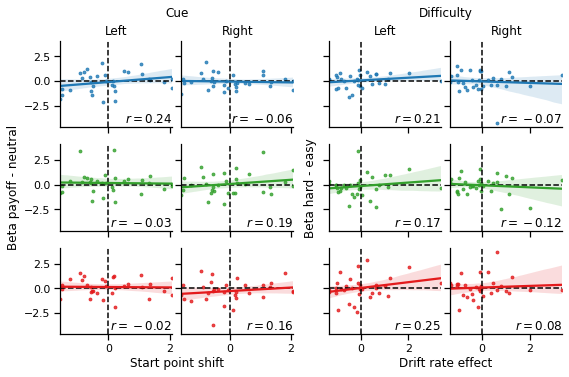

In [18]:
sns.set_context('notebook')
font = {'size'   : 12}
import matplotlib
matplotlib.rc('font', **font)

s = 8
f, ax = plt.subplots(3,5, sharey=True, gridspec_kw={'wspace': 0.1, #'height_ratios': [0.2, 0.8], 
                                                    'width_ratios': [1,1,.15,1,1]}, 
                     figsize=(9,.9*6))
for ax_n in [0,1,3,4]:
    for ax_y in [0,1,2]:
        ax[ax_y,ax_n].axhline(y=0, c='k', ls='--')
        ax[ax_y,ax_n].axvline(x=0, c='k', ls='--')
    
r_ = []
for i, subregion in enumerate(['A', 'B', 'C']):
    r_ = np.corrcoef(combined_data.loc[(combined_data.hemisphere=='l') & (combined_data.subregion==subregion), 'zshiftBias'],
                     combined_data.loc[(combined_data.hemisphere=='l') & (combined_data.subregion==subregion), 'cue_contrast'])[0,1]
    
    sns.regplot(x='zshiftBias', y='cue_contrast', 
                data=combined_data.loc[(combined_data.hemisphere=='l')&(combined_data.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[i,0], # label='$r = ' + str(np.round(r_,2)) + '$', 
                scatter_kws={'s': s})
    ax[i,0].text(x=1, y=0.05, s='$r = ' + str(np.round(r_,2)) + '$', transform=ax[i,0].transAxes, horizontalAlignment='right')
    
ax[0,0].set_title('Left')
_ = [ax[i,0].set_xlabel('') for i in [0,1,2]]
ax[0,0].set_ylabel('')
ax[1,0].set_ylabel('Beta payoff - neutral')
ax[2,0].set_ylabel('')
_ = [ax[i,0].set_xticklabels([]) for i in [0,1]]

for i, subregion in enumerate(['A', 'B', 'C']):
    r_ = np.corrcoef(combined_data.loc[(combined_data.hemisphere=='r') & (combined_data.subregion==subregion), 'zshiftBias'],
                     combined_data.loc[(combined_data.hemisphere=='r') & (combined_data.subregion==subregion), 'cue_contrast'])[0,1]
    sns.regplot(x='zshiftBias', y='cue_contrast', 
                data=combined_data.loc[(combined_data.hemisphere=='r')&(combined_data.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[i,1], label='$r = ' + str(np.round(r_,2)) + '$', 
                scatter_kws={'s': s})
    ax[i,1].text(x=1, y=0.05, s='$r = ' + str(np.round(r_,2)) + '$', transform=ax[i,1].transAxes, horizontalAlignment='right')

ax[0,1].set_title('Right')
_ = [ax[i,1].set_ylabel('') for i in [0,1,2]]
_ = [ax[i,1].set_xlabel('') for i in [0,1,2]]
_ = [ax[i,1].set_xticklabels([]) for i in [0,1]]


for i, subregion in enumerate(['A', 'B', 'C']):
    r_ = np.corrcoef(combined_data.loc[(combined_data.hemisphere=='l')&(combined_data.subregion==subregion), 'vshift'],
                     combined_data.loc[(combined_data.hemisphere=='l')&(combined_data.subregion==subregion), 'difficulty_contrast'])[0,1]
    sns.regplot(x='vshift', y='difficulty_contrast', 
                data=combined_data.loc[(combined_data.hemisphere=='l')&(combined_data.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[i,3], label='$r = ' + str(np.round(r_,2)) + '$',
                scatter_kws={'s': s})
    ax[i,3].text(x=1, y=0.05, s='$r = ' + str(np.round(r_,2)) + '$', transform=ax[i,3].transAxes, horizontalAlignment='right')
#    ax[i,3].legend(loc='lower right', labelspacing=0.1, handletextpad=0.35)

ax[0,3].set_title('Left')
_ = [ax[i,3].set_xlabel('') for i in [0,1,2]]
ax[0,3].set_ylabel('')
ax[1,3].set_ylabel('Beta hard - easy', labelpad=12)
ax[2,3].set_ylabel('')
_ = [ax[i,3].set_xticklabels([]) for i in [0,1]]


for i, subregion in enumerate(['A', 'B', 'C']):
    r_ =  np.corrcoef(combined_data.loc[(combined_data.hemisphere=='r')&(combined_data.subregion==subregion), 'vshift'],
                      combined_data.loc[(combined_data.hemisphere=='r')&(combined_data.subregion==subregion), 'difficulty_contrast'])[0,1]
    sns.regplot(x='vshift', y='difficulty_contrast', 
                data=combined_data.loc[(combined_data.hemisphere=='r')&(combined_data.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[i,4], label='$r = ' + str(np.round(r_,2)) + '$',
                scatter_kws={'s': s})
    ax[i,4].text(x=1, y=0.05, s='$r = ' + str(np.round(r_,2)) + '$', transform=ax[i,4].transAxes, horizontalAlignment='right')
#    ax[i,4].legend(loc='lower right', labelspacing=0.1, handletextpad=0.35)

ax[0,4].set_title('Right')
_ = [ax[i,4].set_ylabel('') for i in [0,1,2]]
_ = [ax[i,4].set_xlabel('') for i in [0,1,2]]
_ = [ax[i,4].set_xticklabels([]) for i in [0,1]]


## subplots title: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
ext = []
#loop over the columns (j) and rows(i) to populate subplots
for j in range(5):
#     for i in range(1):
#         axes[i,j].scatter(x, y[:,4*i+j], c=colors[j], s=25) 
#     # each axes in the top row gets its own axes title
#     axes[0,j].set_title('title {}'.format(j+1))
    # save the axes bounding boxes for later use
    ext.append([ax[1,j].get_window_extent().x0, ax[1,j].get_window_extent().width ])

# from the axes bounding boxes calculate the optimal position of the column spanning title
#f.subplots_adjust(top=0.85)
inv = f.transFigure.inverted()
width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )
width_right = ext[3][0]+(ext[4][0]+ext[4][1]-ext[3][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0],0.95,"Cue", va="center", ha="center", size=12)
plt.figtext(right_center[0],0.95,"Difficulty", va="center", ha="center", size=12)

# x-axis labels
plt.figtext(left_center[0],0.05,"Start point shift", va="center", ha="center", size=12)
plt.figtext(right_center[0],0.05,"Drift rate effect", va="center", ha="center", size=12)

sns.despine()
ax[0,2].axis('off')
ax[1,2].axis('off')
ax[2,2].axis('off')
# for ax_n in [0,1,2,3,4]:
#     ax[0,ax_n].axis('off')
    
#h, l = ax[1,0].get_legend_handles_labels()
#ax[1,0].legend(h, ['A test', 'B test', 'C'], title='Subregion')
#plt.subplots_adjust(right=.95)
#h, l = ax[1,0].get_legend_handles_labels()
#f.legend(h, l, loc='center right', title='Subregion')
f.tight_layout()
#f.savefig('./figures/figure5_3x4.pdf', bbox_inches='tight')
# f.set_size_inches(15,6)

Much better

## Repeat, but now with cue-related drift rate shift
and add Bayes Factors. Attempt 4

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWar

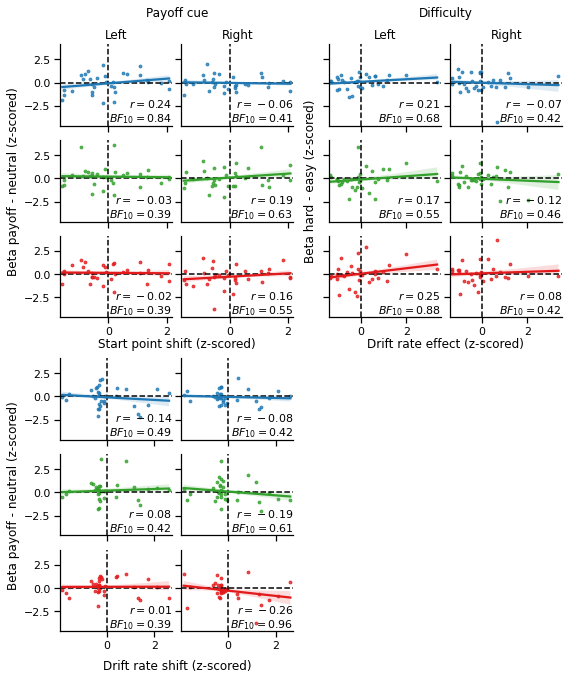

In [19]:
sns.set_context('notebook')
font = {'size'   : 11}
import matplotlib
matplotlib.rc('font', **font)

s = 8
f, ax = plt.subplots(7,5, sharey=True, gridspec_kw={'wspace': 0.1, 'height_ratios': [1,1,1,.15,1,1,1], 
                                                    'width_ratios': [1,1,.15,1,1]}, 
                     figsize=(9,.9*12))
# turn off some axes
for ax_n in [0,1,3,4]:
    for ax_y in [0,1,2,4,5,6]:
        if ax_n > 2 and ax_y > 2:
            continue
        ax[ax_y,ax_n].axhline(y=0, c='k', ls='--')
        ax[ax_y,ax_n].axvline(x=0, c='k', ls='--')


# Bias shift in start point
for col_n, hemisphere in enumerate(['l', 'r']):
    for row_n, subregion in enumerate(['A', 'B', 'C']):
        this_ax = ax[row_n, col_n]
        stats_ = statistics.loc[(statistics['mask'] == 'signal_{}_{}'.format(hemisphere, subregion)) & (statistics['contrast'] == 'zbias'), ['r', 'bf']].values[0]
        sns.regplot(x='zshiftBias', y='cue_contrast', 
                    data=combined_data.loc[(combined_data.hemisphere==hemisphere)&(combined_data.subregion==subregion)], 
                    truncate=True, color=sns.color_palette("Paired")[row_n*2+1],
                    ax=this_ax, 
                    ci=67,
                    scatter_kws={'s': s})
        this_ax.set_xlim(np.array(this_ax.get_xlim())*np.array([1.05, 1.05]))
        this_ax.text(x=1, y=0.05, s='$r = ' + str(np.round(stats_[0],2)) + '$\n$BF_{10}=' + str(np.round(stats_[1],2)) + '$', 
                     transform=this_ax.transAxes, horizontalAlignment='right')
    
ax[0,0].set_title('Left')
_ = [ax[i,0].set_xlabel('') for i in [0,1,2]]
ax[0,0].set_ylabel('')
ax[1,0].set_ylabel('Beta payoff - neutral (z-scored)')
ax[2,0].set_ylabel('')
_ = [ax[i,0].set_xticklabels([]) for i in [0,1]]
ax[0,1].set_title('Right')
_ = [ax[i,1].set_ylabel('') for i in [0,1,2]]
_ = [ax[i,1].set_xlabel('') for i in [0,1,2]]
_ = [ax[i,1].set_xticklabels([]) for i in [0,1]]


# Bias shift in drift rate
for col_n, hemisphere in enumerate(['l', 'r']):
    for row_n, subregion in enumerate(['A', 'B', 'C']):
        row_n += 4
        this_ax = ax[row_n, col_n]
        stats_ = statistics.loc[(statistics['mask'] == 'signal_{}_{}'.format(hemisphere, subregion)) & (statistics['contrast'] == 'vbias'), ['r', 'bf']].values[0]
        sns.regplot(x='vshiftBias', y='cue_contrast', 
                    data=combined_data.loc[(combined_data.hemisphere==hemisphere)&(combined_data.subregion==subregion)], 
                    truncate=True, color=sns.color_palette("Paired")[(row_n-4)*2+1],
                    ax=this_ax,
                    ci=67,
                    scatter_kws={'s': s})
        this_ax.set_xlim(np.array(this_ax.get_xlim())*np.array([1.05, 1.05]))
        this_ax.text(x=1, y=0.05, s='$r = ' + str(np.round(stats_[0],2)) + '$\n$BF_{10}=' + str(np.round(stats_[1],2)) + '$', 
                     transform=this_ax.transAxes, horizontalAlignment='right')

_ = [ax[i,0].set_xlabel('') for i in [4,5,6]]
ax[4,0].set_ylabel('')
ax[5,0].set_ylabel('Beta payoff - neutral (z-scored)')
ax[6,0].set_ylabel('')
_ = [ax[i,0].set_xticklabels([]) for i in [4,5]]
_ = [ax[i,1].set_ylabel('') for i in [4,5,6]]
_ = [ax[i,1].set_xlabel('') for i in [4,5,6]]
_ = [ax[i,1].set_xticklabels([]) for i in [4,5]]


# Diffiuclty shift in drift rate
for col_n, hemisphere in enumerate(['l', 'r']):
    col_n += 3
    for row_n, subregion in enumerate(['A', 'B', 'C']):
        this_ax = ax[row_n, col_n]
        stats_ = statistics.loc[(statistics['mask'] == 'signal_{}_{}'.format(hemisphere, subregion)) & (statistics['contrast'] == 'vdifficulty'), ['r', 'bf']].values[0]
        sns.regplot(x='vshift', y='difficulty_contrast', 
                    data=combined_data.loc[(combined_data.hemisphere==hemisphere)&(combined_data.subregion==subregion)], 
                    truncate=True, color=sns.color_palette("Paired")[row_n*2+1],
                    ax=this_ax,
                    ci=67,
                    scatter_kws={'s': s})
        this_ax.set_xlim(np.array(this_ax.get_xlim())*np.array([1.05, 1.05]))
        this_ax.text(x=1, y=0.05, s='$r = ' + str(np.round(stats_[0],2)) + '$\n$BF_{10}=' + str(np.round(stats_[1],2)) + '$', 
                     transform=this_ax.transAxes, horizontalAlignment='right')

ax[0,3].set_title('Left')
_ = [ax[i,3].set_xlabel('') for i in [0,1,2]]
ax[0,3].set_ylabel('')
ax[1,3].set_ylabel('Beta hard - easy (z-scored)', labelpad=12)
ax[2,3].set_ylabel('')
_ = [ax[i,3].set_xticklabels([]) for i in [0,1]]
ax[0,4].set_title('Right')
_ = [ax[i,4].set_ylabel('') for i in [0,1,2]]
_ = [ax[i,4].set_xlabel('') for i in [0,1,2]]
_ = [ax[i,4].set_xticklabels([]) for i in [0,1]]


## subplots title: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
ext = []
#loop over the columns (j) and rows(i) to populate subplots
for j in range(5):
#     for i in range(1):
#         axes[i,j].scatter(x, y[:,4*i+j], c=colors[j], s=25) 
#     # each axes in the top row gets its own axes title
#     axes[0,j].set_title('title {}'.format(j+1))
    # save the axes bounding boxes for later use
    ext.append([ax[1,j].get_window_extent().x0, ax[1,j].get_window_extent().width ])

# from the axes bounding boxes calculate the optimal position of the column spanning title
#f.subplots_adjust(top=0.85)
inv = f.transFigure.inverted()
width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )
width_right = ext[3][0]+(ext[4][0]+ext[4][1]-ext[3][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0],0.92,"Payoff cue", va="center", ha="center", size=12)
plt.figtext(right_center[0],0.92,"Difficulty", va="center", ha="center", size=12)

# x-axis labels
plt.figtext(left_center[0],0.495,"Start point shift (z-scored)", va="center", ha="center", size=12)
plt.figtext(left_center[0],0.08,"Drift rate shift (z-scored)", va="center", ha="center", size=12)
plt.figtext(right_center[0],0.495,"Drift rate effect (z-scored)", va="center", ha="center", size=12)


sns.despine()
ax[0,2].axis('off')
ax[1,2].axis('off')
ax[2,2].axis('off')
ax[3,2].axis('off')

for col_n in np.arange(5, dtype=int):
    ax[3,col_n].axis('off')

for col_n in [2,3,4]:
    ax[4,col_n].axis('off')
    ax[5,col_n].axis('off')
    ax[6,col_n].axis('off')


# for ax_n in [0,1,2,3,4]:
#     ax[0,ax_n].axis('off')
    
#h, l = ax[1,0].get_legend_handles_labels()
#ax[1,0].legend(h, ['A test', 'B test', 'C'], title='Subregion')
#plt.subplots_adjust(right=.95)
#h, l = ax[1,0].get_legend_handles_labels()
#f.legend(h, l, loc='center right', title='Subregion')
f.tight_layout()
f.savefig('./figures/figure5_6x4-v2.pdf', bbox_inches='tight')
# f.set_size_inches(15,6)